<a href="https://colab.research.google.com/github/jayasrisng/DiffusionExperiment/blob/main/Diffusion_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jayasri Sai Nikitha Guthula

T00708071

CPSC 7373 - Artificial Intelligence

Diffusion Experiment Final Project

Install Dependencies

In [ ]:
def install_dependencies():
    !pip install -qq numpy
    !pip install -qq matplotlib
    !pip install -qq fastai
    !pip install -qq accelerate
    !pip install -qq --upgrade transformers diffusers ftfy

install_dependencies()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.0/852.0 kB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00


Imports and Setup

In [ ]:
import os
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from fastcore.all import concat
from fastai.basics import show_image,show_images
from fastdownload import FastDownload
from pathlib import Path

from PIL import Image
import torch, logging
from torch import autocast
from torchvision import transforms as tfms

from huggingface_hub import notebook_login
from transformers import CLIPTextModel,CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL,UNet2DConditionModel,LMSDiscreteScheduler,StableDiffusionInpaintPipeline

import cv2

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# summarize tensor
_s = lambda x: (x.shape,x.max(),x.min())

Authenticate with Hugging Face

In [ ]:
torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

Load Pretrained Hugging Face Models

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
# hyper parameters match those used during training the model
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);
vae_magic = 0.18215 # vae model trained with a scale term to get closer to unit variance

# Load RunwayML's Inpainting Model
inpaint = StableDiffusionInpaintPipeline.from_pretrained('runwayml/stable-diffusion-inpainting',revision="fp16",torch_dtype=torch.float16).to(torch_device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.16.self_attn.q_proj.weight', 'vision_model.encoder.layers.7.mlp.fc2.bias', 'vision_model.encoder.layers.13.layer_norm1.bias', 'vision_model.encoder.layers.14.self_attn.v_proj.weight', 'vision_model.encoder.layers.3.layer_norm1.weight', 'vision_model.encoder.layers.12.mlp.fc1.bias', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.23.mlp.fc2.weight', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.6.mlp.fc1.bias', 'vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_model.encoder.layers.6.layer_norm1.weight', 'logit_scale', 'vision_model.encoder.layers.11.self_attn.k_proj.weight', 'vision_model.encoder.layers.15.self_attn.k_proj.weight', 'vision_model.encoder.layers.0.self_attn.k_proj.weight', 'vision

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Utility Functions to Convert between Latents and Images

In [ ]:
def image2latent(im):
    im = tfms.ToTensor()(im).unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(im.to(torch_device)*2-1);
    latent = latent.latent_dist.sample() * vae_magic
    return latent

def latents2images(latents):
    latents = latents/vae_magic
    with torch.no_grad():
        imgs = vae.decode(latents).sample
    imgs = (imgs / 2 + 0.5).clamp(0,1)
    imgs = imgs.detach().cpu().permute(0,2,3,1).numpy()
    imgs = (imgs * 255).round().astype("uint8")
    imgs = [Image.fromarray(i) for i in imgs]
    return imgs

def get_embedding_for_prompt(prompt):
    max_length = tokenizer.model_max_length
    tokens = tokenizer([prompt],padding="max_length",max_length=max_length,truncation=True,return_tensors="pt")
    with torch.no_grad():
        embeddings = text_encoder(tokens.input_ids.to(torch_device))[0]
    return embeddings

DiffEdit Implementation

In [ ]:
# Given a starting image latent and a prompt; predict the noise that should be removed to transform
# the noised source image to a denoised image guided by the prompt.
def predict_noise(text_embeddings,im_latents,seed=torch.seed(),guidance_scale=7,strength=0.5,**kwargs):
    num_inference_steps = 50            # Number of denoising steps

    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise

    uncond = get_embedding_for_prompt('')
    text_embeddings = torch.cat([uncond, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    offset = scheduler.config.get("steps_offset", 0)
    init_timestep = int(num_inference_steps * strength) + offset
    init_timestep = min(init_timestep, num_inference_steps)

    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps] * 1 * 1, device=torch_device)

    start_step = init_timestep
    noise = torch.randn_like(im_latents)
    latents = scheduler.add_noise(im_latents,noise,timesteps=timesteps)
    latents = latents.to(torch_device).float()

    t_start = max(num_inference_steps - init_timestep + offset, 0)
    timesteps = scheduler.timesteps[t_start:].to(torch_device)

    noisy_latent = latents.clone()

    noise_pred = None
    for i, tm in enumerate(timesteps):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, tm)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, tm, encoder_hidden_states=text_embeddings)["sample"]

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

        u = noise_pred_uncond
        g = guidance_scale
        t = noise_pred_text

        # perform guidance
        noise_pred = u + g * (t - u)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, tm, latents).prev_sample

    return latents2images(latents)[0],noise_pred

In [ ]:
# For a given reference prompt and a query prompt;
# Run the diffusion process 10 times; Calculating a "noise distance" for each sample
def calc_diffedit_samples(encoded,prompt1,prompt2,n=10,**kwargs):
    diffs=[]
    # So we can reproduce mask generation we generate a list of n seeds
    torch.manual_seed(torch.seed() if 'seed' not in kwargs else kwargs['seed'])
    seeds = torch.randint(0,2**62,(10,)).tolist()
    for i in range(n):
        kwargs['seed'] = seeds[i] # Important to use same seed for the two noise samples
        emb1 = get_embedding_for_prompt(prompt1)
        _im1,n1 = predict_noise(emb1,encoded,**kwargs)
        emb2 = get_embedding_for_prompt(prompt2)
        _im2,n2 = predict_noise(emb2,encoded,**kwargs)

        # Aggregate the channel components by taking the euclidean distance.
        diffs.append((n1-n2)[0].pow(2).sum(dim=0).pow(0.5)[None])
    all_masks = torch.cat(diffs)
    return all_masks

# Given an image latent and two prompts; generate a grayscale diff by sampling the noise predictions
# between the prompts.
def calc_diffedit_diff(im_latent,p1,p2,**kwargs):
    m = calc_diffedit_samples(im_latent,p1,p2,**kwargs)
    m = m.mean(axis=0) # average samples together
    m = (m-m.min())/(m.max()-m.min()) # rescale to interval [0,1]
    m = (m*255.).cpu().numpy().astype(np.uint8)
    m = Image.fromarray(m)
    return m

# Try to improve the mask thru convolutions etc
# assume m is a PIL object containing a grayscale 'diff'
def process_diffedit_mask(m,threshold=0.35,**kwargs):
    m = np.array(m).astype(np.float32)
    m = cv2.GaussianBlur(m,(5,5),1)
    m = (m>(255.*threshold)).astype(np.float32)*255
    m = Image.fromarray(m.astype(np.uint8))
    return m

# Given an image latent and two prompts; generate a binarized mask (PIL) appropriate for inpainting
def calc_diffedit_mask(im_latent,p1,p2,**kwargs):
    m = calc_diffedit_diff(im_latent,p1,p2,**kwargs)
    m = process_diffedit_mask(m,**kwargs)
    m = m.resize((512,512))
    return m

In [ ]:
# Composite the mask over the provided image; for demonstration purposes
def get_blended_mask(im,mask_gray): # Both expected to be PIL images
    mask_rgb = mask_gray.convert('RGB')
    return Image.blend(im,mask_rgb,0.40)

# Show the original image, the original image with mask and the resulting inpainted image
def demo_diffedit(im_path,p1,p2,**kwargs):
    im_path = Path(im_path)
    out = []

    im = Image.open(im_path).resize((512,512))
    im_latent = image2latent(im)
    out.append(im)

    if 'seed' not in kwargs: kwargs['seed'] = torch.seed()
    mask = calc_diffedit_mask(im_latent,p1,p2,**kwargs)
    out.append(get_blended_mask(im,mask))
    out.append(inpaint(prompt=[p2],image=im,mask_image=mask,
        generator=torch.Generator(torch_device).manual_seed(kwargs['seed'])).images[0])
    show_images(out)

Demonstrate Mask Generation

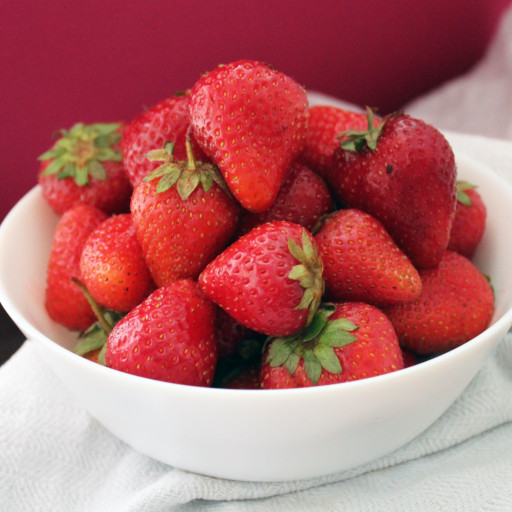

In [ ]:
#Load an image
p = FastDownload().download('https://raw.githubusercontent.com/johnrobinsn/diffusion_experiments/main/images/bowloberries_scaled.jpg')
im = Image.open(p).resize((512,512));im

In [ ]:
latent = image2latent(im); latent.shape

torch.Size([1, 4, 64, 64])

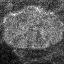

In [ ]:
seed = 12765083811071779585
#seed = torch.seed()
print('seed:',seed)
mask = calc_diffedit_diff(latent,'Bowl of Strawberries','Bowl of Oranges',seed=seed)
mask # resample from 64x64 pixel mask to size of original image for ease of view

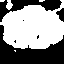

In [ ]:
binarized_mask = process_diffedit_mask(mask)
binarized_mask

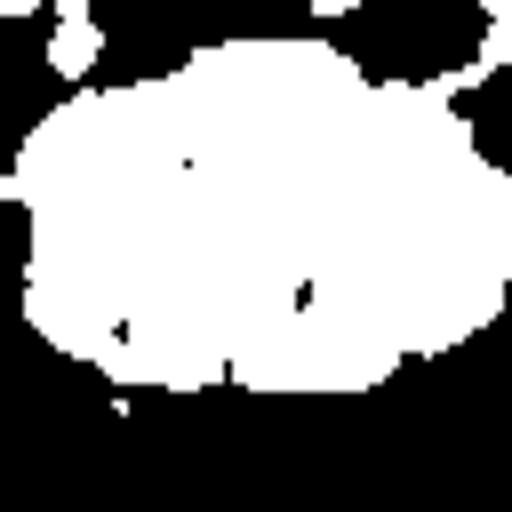

In [ ]:
binarized_mask = binarized_mask.resize((512,512))
binarized_mask

  0%|          | 0/50 [00:00<?, ?it/s]

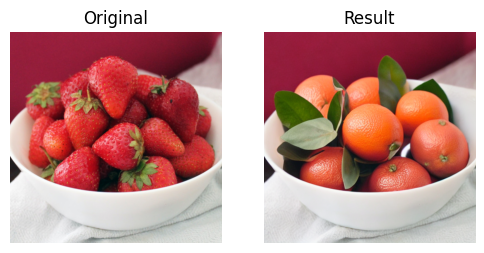

In [ ]:
seed = 16428495079677868580
#seed = torch.seed()
print('seed:',seed)
generator = torch.Generator(torch_device).manual_seed(seed)
im_result = inpaint(prompt=['Bowl of Oranges'],image=im,mask_image=binarized_mask,generator=generator).images[0]
show_images([im,im_result],titles=['Original','Result'])